In [1]:
BLACKHOLE = False


import os
import sys
from pathlib import Path
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE" # fixes problem with graph


if BLACKHOLE:
    workspace_path = os.path.expandvars('$BLACKHOLE')
    sys.path.append(workspace_path+'/DeepLearning/02456_news_project/src')
    DATAPATH = Path(workspace_path+"/DeepLearning/ebnerd_data").expanduser()
else:
    DATAPATH = Path("~/ebnerd_data").expanduser()

DATASET = "ebnerd_demo"
#DATASET = "ebnerd_small"
#DATASET = "ebnerd_large"

In [2]:
import torch

print("torch version:", torch.__version__)

# Check gpu availability


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Test:
#print(torch.zeros(1).cuda())

torch version: 2.5.1+cu124
cuda


In [3]:
from utils.data_handler import NewsDataset
import from_ebrec._constants as cs

SEED = 42
HISTORY_SIZE = 30
CANDITATE_SIZE = 5

COLS = [
    cs.DEFAULT_USER_COL,
    cs.DEFAULT_IMPRESSION_ID_COL,
    cs.DEFAULT_IMPRESSION_TIMESTAMP_COL,
    cs.DEFAULT_HISTORY_ARTICLE_ID_COL,
    cs.DEFAULT_CLICKED_ARTICLES_COL,
    cs.DEFAULT_INVIEW_ARTICLES_COL,
]

#FRACTION = 0.001
#FRACTION = 0.01
#FRACTION = 0.1
FRACTION = 1

# test
dataset = NewsDataset()

dataset.setup_df(dataset_path = DATAPATH, datasplit = DATASET, history_size = HISTORY_SIZE, columns = COLS, fraction = FRACTION, seed = SEED, candidate_size=CANDITATE_SIZE)


In [4]:
import transformers as huggingface
from from_ebrec._nlp import get_transformers_word_embeddings
from from_ebrec._polars import concat_str_columns
from from_ebrec._articles import convert_text2encoding_with_transformers
from from_ebrec._articles import create_article_id_to_value_mapping

dataset.setup_articles_data(dataset_path = DATAPATH.joinpath(DATASET))

df_articles = dataset.df_articles

TRANSFORMER_MODEL_NAME = "FacebookAI/xlm-roberta-large"
TEXT_COLUMNS_TO_USE = [cs.DEFAULT_SUBTITLE_COL, cs.DEFAULT_TITLE_COL]
MAX_TITLE_LENGTH = 30

# LOAD HUGGINGFACE:
transformer_model = huggingface.AutoModel.from_pretrained(TRANSFORMER_MODEL_NAME)
transformer_tokenizer = huggingface.AutoTokenizer.from_pretrained(TRANSFORMER_MODEL_NAME)

word2vec_embedding = get_transformers_word_embeddings(transformer_model)
df_articles, cat_cal = concat_str_columns(df_articles, columns=TEXT_COLUMNS_TO_USE)
df_articles, token_col_title = convert_text2encoding_with_transformers(df_articles, transformer_tokenizer, cat_cal, max_length=MAX_TITLE_LENGTH)
article_mapping = create_article_id_to_value_mapping(df=df_articles, value_col=token_col_title)



In [5]:
from nrms import NRMSModel
from hyperparameters import hparams_nrms

hparams = hparams_nrms()

BATCH_SIZE = 64

# PARAMETERS
hparams.title_size = MAX_TITLE_LENGTH
hparams.history_size = HISTORY_SIZE
hparams.batch_size = BATCH_SIZE
hparams.candidate_size = CANDITATE_SIZE

# MODEL ARCHITECTURE
hparams.head_num = 32
hparams.head_dim = 32
hparams.attention_hidden_dim = 200
hparams.linear_hidden_dim = 200
hparams.embedding_dim = word2vec_embedding.shape[1]

hparams.use_positional_encoding = True

hparams.use_time_embedding = False
hparams.time_dim = 1
hparams.time_embedding_dim = 32

# MODEL OPTIMIZER:
hparams.optimizer = "adam"
hparams.loss = "mse_loss"
hparams.dropout = 0.2
hparams.learning_rate = 1e-4

model = NRMSModel(hparams=hparams, word2vec_embedding=word2vec_embedding)

print(model)


NRMSModel(
  (news_encoder): NewsEncoder(
    (embedding): Embedding(250002, 1024)
    (dropout): Dropout(p=0.2, inplace=False)
    (positional_encoder): PositionEncoder(
      (dropout): Dropout(p=0.2, inplace=False)
    )
    (self_attention): SelfAttention(
      (query_proj): Linear(in_features=1024, out_features=1024, bias=True)
      (key_proj): Linear(in_features=1024, out_features=1024, bias=True)
      (value_proj): Linear(in_features=1024, out_features=1024, bias=True)
    )
    (dense_layers): Sequential(
      (0): Linear(in_features=1024, out_features=200, bias=True)
      (1): ReLU()
      (2): LayerNorm((200,), eps=1e-05, elementwise_affine=True)
      (3): Dropout(p=0.2, inplace=False)
      (4): Linear(in_features=200, out_features=200, bias=True)
      (5): ReLU()
      (6): LayerNorm((200,), eps=1e-05, elementwise_affine=True)
      (7): Dropout(p=0.2, inplace=False)
      (8): Linear(in_features=200, out_features=1024, bias=True)
      (9): ReLU()
      (10): LayerN

In [6]:
import torch.nn as nn
import torch.optim as optim

# Define the loss function and optimizer
if hparams.loss == "cross_entropy_loss":
    criterion = nn.CrossEntropyLoss() 
elif hparams.loss == "mse_loss":
    criterion = nn.MSELoss()
else:
    raise ValueError(f"Loss function {hparams.loss} not supported")

if hparams.optimizer == "adam":
    optimizer = optim.Adam(model.parameters(), lr=hparams_nrms.learning_rate)
else:
    raise ValueError(f"Optimizer {hparams.optimizer} not supported")

In [7]:
from dataloader import NRMSDataLoader


train_dataloader = NRMSDataLoader(
    behaviors= dataset.df_train,
    article_dict=article_mapping,
    unknown_representation="zeros",
    history_column= cs.DEFAULT_HISTORY_ARTICLE_ID_COL,
    batch_size=BATCH_SIZE,
)
val_dataloader = NRMSDataLoader(
    behaviors= dataset.df_validation,
    article_dict=article_mapping,
    unknown_representation="zeros",
    history_column= cs.DEFAULT_HISTORY_ARTICLE_ID_COL,
    batch_size=BATCH_SIZE,
)

In [8]:
# Train the model 

EPOCHS = 10

# Move model to GPU if available
model.to(device)

# Training loop
train_loss_history, val_loss_history = [], []

for epoch in range(EPOCHS):
    model.train()  # Set the model to training mode
    train_loss = 0.0
    for iteration, (data, labels) in enumerate(train_dataloader):
        # Unpacking of batch
        his_input_title, pred_input_title = data

        # Move data to device
        his_input_title = his_input_title.to(device)
        pred_input_title = pred_input_title.to(device)

        labels = labels.to(device)

        # Forward pass
        outputs = model(pred_input_title, his_input_title)
        loss = criterion(outputs, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        print(f"Epoch {epoch + 1}/{EPOCHS}, Train iteration {iteration + 1}/{len(train_dataloader)}: Loss = {loss.item():.4f}")

    # Validation loop
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for iteration, (data, labels) in enumerate(val_dataloader):
            his_input_title, pred_input_title = data

            his_input_title = his_input_title.to(device)
            pred_input_title = pred_input_title.to(device)
            labels = labels.to(device)

            outputs = model(pred_input_title, his_input_title)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()

            print(f"Epoch {epoch + 1}/{EPOCHS}, Val iteration {iteration + 1}/{len(val_dataloader)}: Loss = {loss.item():.4f}")

    train_loss /= len(train_dataloader)
    val_loss /= len(val_dataloader)
    train_loss_history.append(train_loss)
    val_loss_history.append(val_loss)

    print(f"Epoch {epoch + 1}/{EPOCHS}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}")


Epoch 1/10, Train iteration 1/336: Loss = 0.2346
Epoch 1/10, Train iteration 2/336: Loss = 0.2657
Epoch 1/10, Train iteration 3/336: Loss = 0.2484
Epoch 1/10, Train iteration 4/336: Loss = 0.2667
Epoch 1/10, Train iteration 5/336: Loss = 0.2202
Epoch 1/10, Train iteration 6/336: Loss = 0.2568
Epoch 1/10, Train iteration 7/336: Loss = 0.2394
Epoch 1/10, Train iteration 8/336: Loss = 0.2301
Epoch 1/10, Train iteration 9/336: Loss = 0.2583
Epoch 1/10, Train iteration 10/336: Loss = 0.2229
Epoch 1/10, Train iteration 11/336: Loss = 0.2273
Epoch 1/10, Train iteration 12/336: Loss = 0.2377
Epoch 1/10, Train iteration 13/336: Loss = 0.2277
Epoch 1/10, Train iteration 14/336: Loss = 0.2065
Epoch 1/10, Train iteration 15/336: Loss = 0.2197
Epoch 1/10, Train iteration 16/336: Loss = 0.2404
Epoch 1/10, Train iteration 17/336: Loss = 0.2167
Epoch 1/10, Train iteration 18/336: Loss = 0.2417
Epoch 1/10, Train iteration 19/336: Loss = 0.2536
Epoch 1/10, Train iteration 20/336: Loss = 0.2221
Epoch 1/1

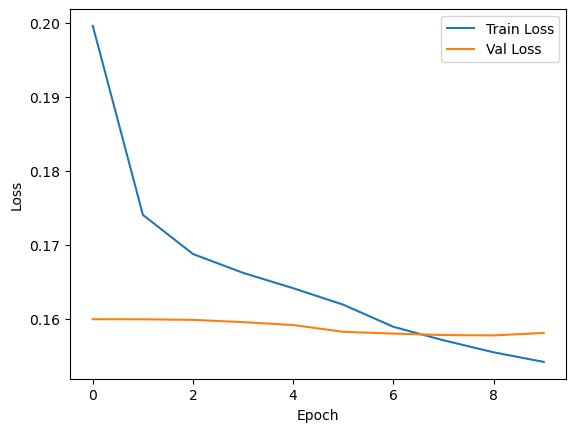

In [9]:
# Plot the loss history
import matplotlib.pyplot as plt

plt.plot(train_loss_history, label="Train Loss")
plt.plot(val_loss_history, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [10]:
# Evaluate the model
BATCH_SIZE_TEST = 10

dataset.setup_test_data(dataset_path = DATAPATH, datasplit = DATASET, history_size = HISTORY_SIZE, columns = COLS, fraction = FRACTION, seed = SEED, candidate_size=CANDITATE_SIZE)

test_dataloader = NRMSDataLoader(
    behaviors=dataset.df_test,
    article_dict=article_mapping,
    unknown_representation="zeros",
    history_column=cs.DEFAULT_HISTORY_ARTICLE_ID_COL,
    batch_size=BATCH_SIZE_TEST,
)

model.eval()

test_loss = 0.0
pred_test = []
labels_test = []
with torch.no_grad():  
    for iteration, (data, labels) in enumerate(test_dataloader):
        his_input_title, pred_input_title = data

        his_input_title = his_input_title.to(device)
        pred_input_title = pred_input_title.to(device)
        labels = labels.to(device)

        outputs = model(pred_input_title, his_input_title) 
        loss = criterion(outputs, labels)                 
        test_loss += loss.item()

        for i in range(outputs.size(0)):
            pred_test.append(outputs[i].tolist())
            labels_test.append(labels[i].tolist())

        print(f"Test iteration {iteration + 1}/{len(test_dataloader)}: Loss = {loss.item():.4f}")

    test_loss /= len(test_dataloader)
    print("Test loss:", test_loss)
        
print(pred_test)
print(labels_test)

from from_ebrec.evaluation import MetricEvaluator
from from_ebrec.evaluation import AucScore, MrrScore, NdcgScore
metrics = MetricEvaluator(
    labels = labels_test,
    predictions= pred_test,
    metric_functions=[AucScore(), MrrScore(), NdcgScore(k=5), NdcgScore(k=10)],
)
metrics.evaluate()
print(metrics)



Test iteration 1/2551: Loss = 0.1733
Test iteration 2/2551: Loss = 0.1559
Test iteration 3/2551: Loss = 0.1669
Test iteration 4/2551: Loss = 0.1597
Test iteration 5/2551: Loss = 0.1720
Test iteration 6/2551: Loss = 0.1433
Test iteration 7/2551: Loss = 0.1507
Test iteration 8/2551: Loss = 0.1560
Test iteration 9/2551: Loss = 0.1633
Test iteration 10/2551: Loss = 0.1540
Test iteration 11/2551: Loss = 0.1552
Test iteration 12/2551: Loss = 0.1640
Test iteration 13/2551: Loss = 0.1645
Test iteration 14/2551: Loss = 0.1591
Test iteration 15/2551: Loss = 0.1494
Test iteration 16/2551: Loss = 0.1186
Test iteration 17/2551: Loss = 0.1461
Test iteration 18/2551: Loss = 0.1756
Test iteration 19/2551: Loss = 0.1615
Test iteration 20/2551: Loss = 0.1640
Test iteration 21/2551: Loss = 0.1401
Test iteration 22/2551: Loss = 0.1583
Test iteration 23/2551: Loss = 0.1665
Test iteration 24/2551: Loss = 0.1594
Test iteration 25/2551: Loss = 0.1677
Test iteration 26/2551: Loss = 0.1613
Test iteration 27/255

AUC: 100%|██████████████████████████████| 25505/25505 [00:02<00:00, 9587.45it/s]

<MetricEvaluator class>: 
 {
    "auc": 0.5267986669280533,
    "mrr": 0.499440632555708,
    "ndcg@5": 0.6215710337910796,
    "ndcg@10": 0.6215710337910796
}


In [11]:
number_to_print = 20
print("Top %d predictions vs labels:" % number_to_print)
labels = dataset.df_test["labels"].to_list()
for i in range(number_to_print):
    print(f"Article {i}")
    for j in range(len(pred_test[i])):
        print(f"{pred_test[i][j]:.3f} vs {labels[i][j]:.3f}")
    print("")





Top 20 predictions vs labels:
Article 0
0.187 vs 0.000
0.309 vs 0.000
0.187 vs 0.000
0.153 vs 0.000
0.165 vs 1.000

Article 1
0.266 vs 0.000
0.185 vs 0.000
0.196 vs 0.000
0.185 vs 0.000
0.167 vs 1.000

Article 2
0.156 vs 1.000
0.239 vs 0.000
0.157 vs 0.000
0.239 vs 0.000
0.208 vs 0.000

Article 3
0.190 vs 0.000
0.190 vs 0.000
0.272 vs 0.000
0.214 vs 0.000
0.133 vs 1.000

Article 4
0.168 vs 0.000
0.130 vs 0.000
0.328 vs 0.000
0.130 vs 0.000
0.244 vs 1.000

Article 5
0.208 vs 0.000
0.197 vs 1.000
0.219 vs 0.000
0.157 vs 0.000
0.219 vs 0.000

Article 6
0.152 vs 1.000
0.149 vs 0.000
0.242 vs 0.000
0.229 vs 0.000
0.229 vs 0.000

Article 7
0.218 vs 0.000
0.196 vs 1.000
0.208 vs 0.000
0.218 vs 0.000
0.160 vs 0.000

Article 8
0.219 vs 0.000
0.272 vs 0.000
0.178 vs 1.000
0.219 vs 0.000
0.112 vs 0.000

Article 9
0.134 vs 1.000
0.153 vs 0.000
0.260 vs 0.000
0.193 vs 0.000
0.260 vs 0.000

Article 10
0.212 vs 0.000
0.140 vs 0.000
0.197 vs 0.000
0.197 vs 0.000
0.253 vs 1.000

Article 11
0.041 vs 0.0

Confusion Matrix:
[[102007     13]
 [ 25495     10]]


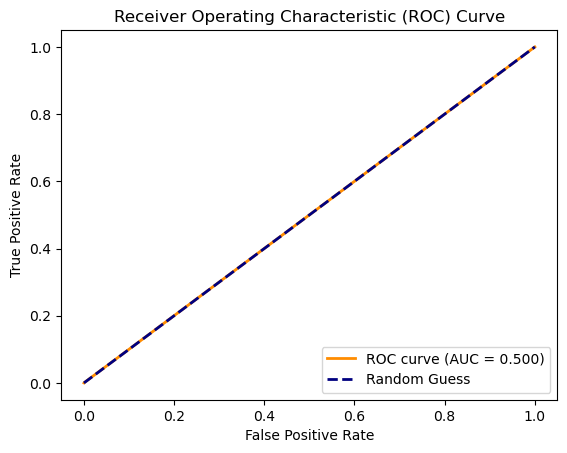

In [12]:
from sklearn.metrics import confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt


# Flatten the data for analysis
predicted_probabilities = [prob for article in pred_test for prob in article]
true_values = [val for article in labels[:len(pred_test)] for val in article]


# Set a threshold (commonly 0.5) to classify probabilities as 0 or 1
threshold = 0.5
predicted_classes = [1 if p >= threshold else 0 for p in predicted_probabilities]

# Calculate confusion matrix
conf_matrix = confusion_matrix(true_values, predicted_classes)
print("Confusion Matrix:")
print(conf_matrix)

# Calculate AUC and ROC curve
fpr, tpr, thresholds = roc_curve(true_values, predicted_classes)
roc_auc = auc(fpr, tpr)

# Plot ROC curve with AUC value explicitly highlighted
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label="Random Guess")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()